In [2]:
# Import modules

import networkx as nx
import matplotlib.pyplot as plt
import json
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np

from dimod import BinaryQuadraticModel
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave_networkx as dnx
import dwave.inspector

from plotters import plotHistogram, plotBoundaryStrength, plotSampleGraph, plotArrangement, annotateSampleGraph
from qubo import createBQM
from sampleRecording import recordSample, plotCSV, findOverlaps, totalEntropy

In [3]:
identifier = "Haydn"
path = path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
bqm = BinaryQuadraticModel.from_serializable(json.load(open(path + "bqm.json", "r")))
embedding = json.load(open(path + "embedding.json", "r"))

sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)

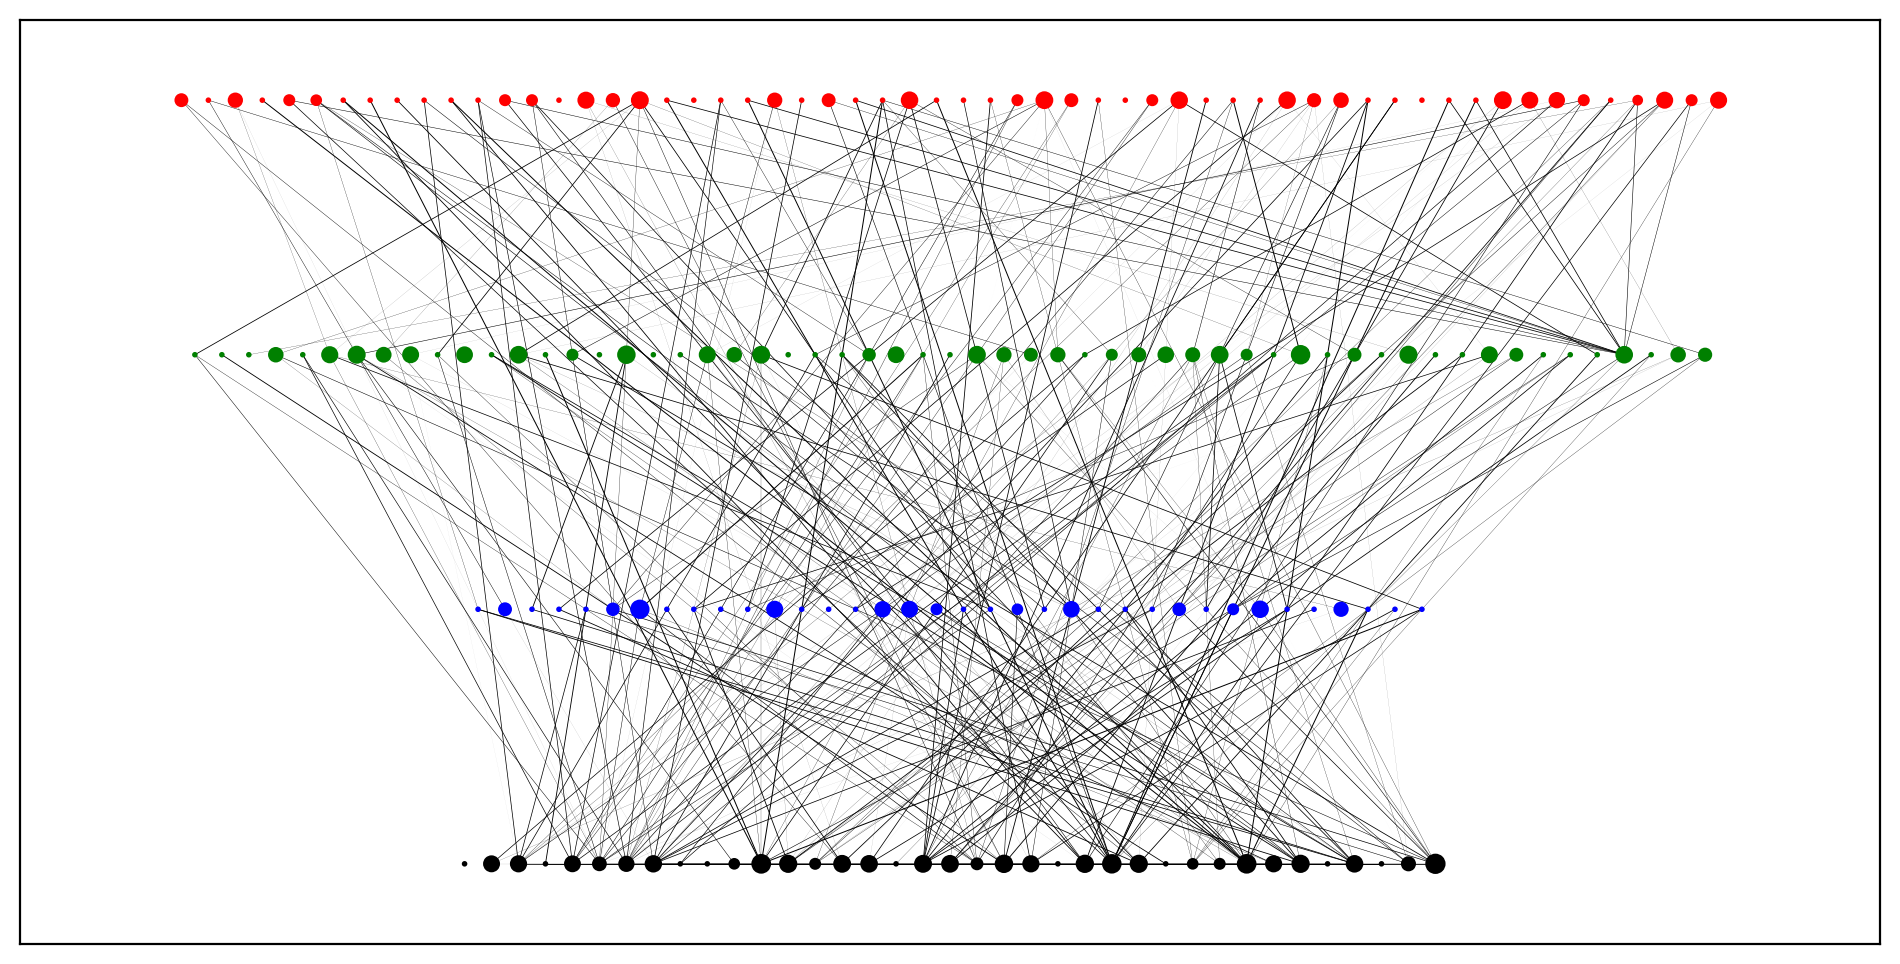

In [3]:
bqm = createBQM(G, phrases, instruments, 1, 12, 1)
sampleset = sampler.sample(bqm, num_reads=1000, label=f"Haydn_{1000}")
plotSampleGraph(sampleset.first.sample, G)

In [ ]:
# Start with both multipliers as 1
# Vary node multiplier to find best
# Vary edge multiplier to find best
# Theoretically no overlaps once both varied

# Edge multiplier = 12 prevents overlaps without increasing energy too much
# Now can vary total anneals
# Compare to energy and total entropy
# Plot with solution from classical methods

multipliers = np.arange(5,20,1)

file = pd.DataFrame()
for m in multipliers:
    bqm = createBQM(G, phrases, instruments, 1, m, 1)
    sampleset = sampler.sample(bqm, num_reads=2000, label=f"Haydn_{2000}")
    sample = sampleset.first

    A = annotateSampleGraph(sample.sample, G)
    new_row = pd.DataFrame({
        "Multiplier": [m],
        "Lowest energy": [bqm.energy(sample.sample)],
        "Chain break fraction": [sample.chain_break_fraction],
        "Overlaps": findOverlaps(A)
        })
    
    file = pd.concat([file, new_row])
    
    print(f"Multiplier {m} recorded!")

file.to_csv(path+"edge-mult.csv", index=False, mode="a", header=False)
#recordSample(path+"samples.csv", results, reads)

Multiplier 5 recorded!
Multiplier 6 recorded!
Multiplier 7 recorded!
Multiplier 8 recorded!
Multiplier 9 recorded!
Multiplier 10 recorded!
Multiplier 11 recorded!
Multiplier 12 recorded!
Multiplier 13 recorded!
Multiplier 14 recorded!
Multiplier 15 recorded!
Multiplier 16 recorded!
Multiplier 17 recorded!
Multiplier 18 recorded!
Multiplier 19 recorded!


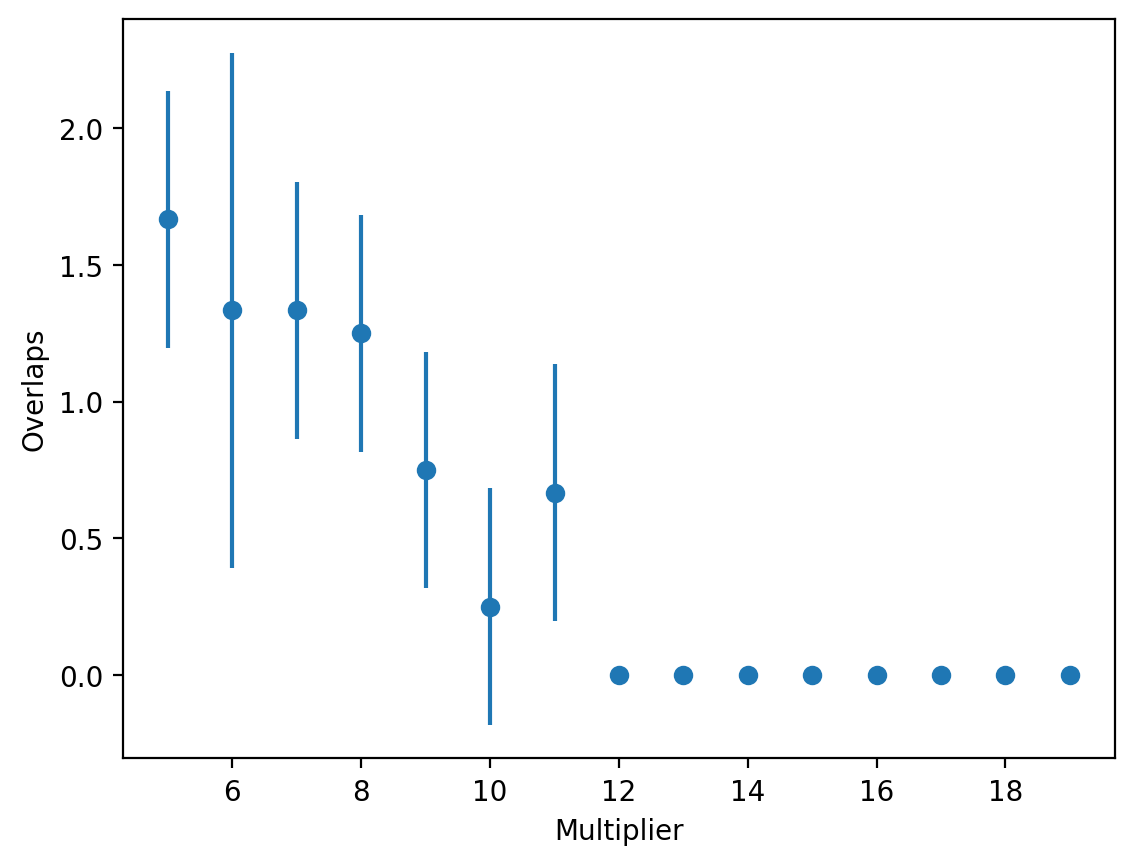

In [5]:
plotCSV(path+"edge-mult.csv", "Multiplier", "Overlaps", np.arange(5,20,1))

In [53]:
print(2000//3000)

0


In [5]:
no_reads = range(12000, 20001, 1000)
max_reads = 3000

bqm = createBQM(G, phrases, instruments, 1, 12, 1)

for total_reads in no_reads:

    if total_reads <= max_reads:
        sampleset = sampler.sample(bqm, num_reads=total_reads, label=f"Haydn_{total_reads}")
    
    else:
        sampleset = sampler.sample(bqm, num_reads=max_reads, label=f"Haydn_{total_reads}_{max_reads}")
        reads = total_reads - max_reads

        while reads > 0:
            if reads <= max_reads:
                new_sampleset = sampler.sample(bqm, num_reads=reads, label=f"Haydn_{total_reads}_{reads}")
                reads = 0

            else:
                new_sampleset = sampler.sample(bqm, num_reads=max_reads, label=f"Haydn_{total_reads}_{max_reads}")
                reads -= max_reads

            if new_sampleset.first.energy < sampleset.first.energy:
                sampleset = new_sampleset

    A = annotateSampleGraph(sampleset.first.sample, G)

    new_row = pd.DataFrame({
        "Total reads": [total_reads],
        "Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
        "Anneal time": [sampleset.info["timing"]["qpu_anneal_time_per_sample"]],
        "QPU time": [sampleset.info["timing"]["qpu_access_time"]],
        "Lowest energy": [sampleset.first.energy],
        "Chain break fraction": [sampleset.first.chain_break_fraction],
        "Overlaps": [findOverlaps(A)],
        "Total entropy": [totalEntropy(A)]
        })

    new_row.to_csv(path+"total-reads.csv", index=False, mode="a", header=False)
    print(f"Recorded {total_reads} reads")

Recorded 0 reads
Recorded 0 reads
Recorded 0 reads
Recorded 0 reads
Recorded 0 reads
Recorded 0 reads
Recorded 0 reads
Recorded 0 reads
Recorded 0 reads


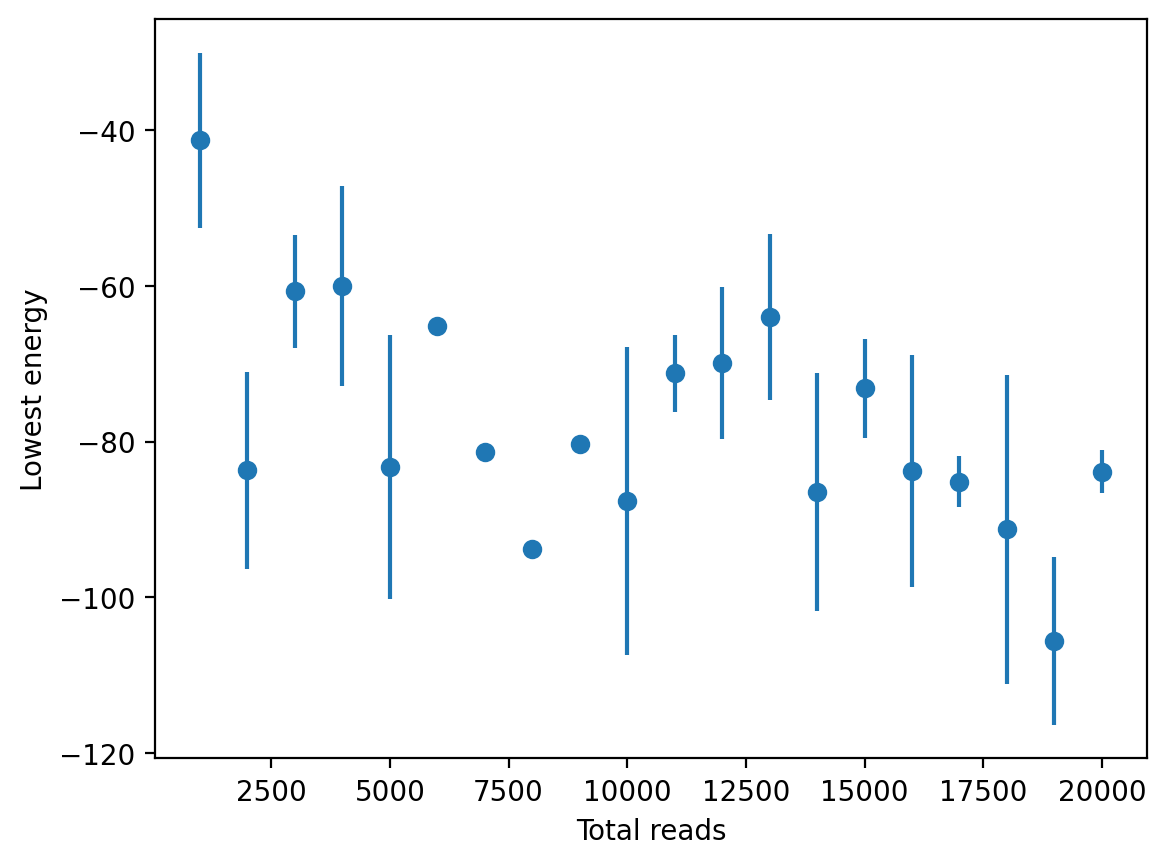

In [9]:
plotCSV(path+"total-reads.csv", "Total reads", "Lowest energy", range(1000,20001,1000))

In [ ]:
# Show results

#plotArrangement(sample, phrases, instruments)

In [ ]:
sampler = SimulatedAnnealingSampler()
reads = 1000

results = sampler.sample(bqm, num_reads=reads)
df = results.to_pandas_dataframe(True)

plotSampleGraph(df["sample"][0], G, [phrase for part in phrases for phrase in part])

In [ ]:
# Solve classically

sd = SteepestDescentSolver()
sa = SimulatedAnnealingSampler()

# Compare energies from different methods
# Just because it doesn't crash doesn't mean it passed

for reads in no_reads:
    for _ in range(repeats):
        results = sa.sample(bqm, num_reads=reads)
        new_row = pd.DataFrame({
            "Total reads": [reads],
            "Lowest energy": [results.first.energy],
        })

        new_row.to_csv(path + "simulated.csv", index=False, mode="a", header=False)

    print(f"Recorded {reads} reads")

In [ ]:
simulated = pd.read_csv(path + "simulated.csv")
plotEnergyAgainstReads(simulated)
plotEnergyAgainstReads(samples)

In [ ]:
print(results.info.keys())
print(results.info["embedding_context"]["chain_strength"])
print(results.info["timing"]["qpu_anneal_time_per_sample"])
print(results.info["timing"]["qpu_access_time"])
print(results.info["timing"])
print(results.first.energy)
print(bqm.energy(results.first.sample))
print(results.first.sample)
print(results.first.chain_break_fraction)

In [ ]:
plotHistogram(df)
print(df.head())
print(bqm.energy(df["sample"][0]))

In [ ]:
chain_strengths = [10, 20, 30, 40, 50, 60, 70, 80, 90]
sampler = FixedEmbeddingComposite(DWaveSampler(), embedding)
reads = 500
anneal_time = 400

for cs in chain_strengths:
    sampleset = sampler.sample(bqm, num_reads=reads, annealing_time=300, chain_strength=cs, label=f"Haydn_{reads}r_{anneal_time}us").to_pandas_dataframe(True)
    plt.subplot(3, 3, chain_strengths.index(cs)+1, sharex=True, sharey=True)
    plt.title(f"Chain Strength: {cs}")
    plotHistogram(sampleset)

plt.show()

In [ ]:

#arrangement.write(fmt="musicxml.pdf", fp="../Figures/poly.pdf", dpi=300)

# TODO: Bias selection of phrases to specific parts (e.g. by checking ambitus)
# TODO: Add meaningful edge weightings
# TODO: Are there more efficient ways to add constraints?

# TODO: Solution quality against problem size
# TODO: Number of qubits against problem size
# TODO: Time to solution against problem size